<a href="https://colab.research.google.com/github/sayan3710/Neural-Machine-Translation/blob/master/NMT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import os
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time
import math
import matplotlib.ticker as ticker
from nltk.translate.bleu_score import corpus_bleu

In [2]:
print(torch.cuda.get_device_name())

Tesla P4


# Loading the vocabulary into seperate dictionaries to correspond to word_to_index and index_to_word for both the languages.

In [0]:
def create_vocabs(s):
  word_idx = {'<PAD>':0} # english vocabulary dictionary provides the index for the given word
  idx_word = {0:'<PAD>'} # given the index provides the word
  c=1
  with open(s) as f:
      for line in f:
        idx_word[c] = line[:-1]
        word_idx[line[:-1]]=c
        c+=1
  return(word_idx,idx_word)

In [0]:
eng_idx,idx_eng = create_vocabs("/content/drive/My Drive/nmt/vocab_en.txt")
viet_idx,idx_viet = create_vocabs("/content/drive/My Drive/nmt/vocab_vi.txt")

In [5]:
print("English vocabulary\n")
for i in range(15):
  print("{}:{}".format(i,idx_eng[i]))

print("\n\nVietnamese vocabulary\n")
for i in range(15):
  print("{}:{}".format(i,idx_viet[i]))

English vocabulary

0:<PAD>
1:<unk>
2:<s>
3:</s>
4:Rachel
5::
6:The
7:science
8:behind
9:a
10:climate
11:headline
12:In
13:4
14:minutes


Vietnamese vocabulary

0:<PAD>
1:<unk>
2:<s>
3:</s>
4:Khoa
5:học
6:đằng
7:sau
8:một
9:tiêu
10:đề
11:về
12:khí
13:hậu
14:Trong


Note: that in both these dictionaries :

"\<PAD\> marks the padding to keep a constant length in the coder and decoder sequence"

"\<unk\> marks the end of sentence"

"\<s\> marks the beginning oif the sentence"

"\</s\> marks the end of the sentence"

# Creating the training set for with the padded special symbols for to specify the start of a sentence and end of the sentence.

In [0]:
def create_training(s):
  train=[]
  train_len=[]
  with open(s) as f:
    for line in f:
      train.append(idx_eng[2] +" "+ line[:-1] +" "+ idx_eng[3])
      train_len.append(len((idx_eng[2] +" "+ line[:-1] +" "+ idx_eng[3]).split()))
  return train,np.array(train_len)



In [0]:
en,len_en = create_training("/content/drive/My Drive/nmt/train_en.txt")
vi,len_vi = create_training('/content/drive/My Drive/nmt/train_vi.txt')

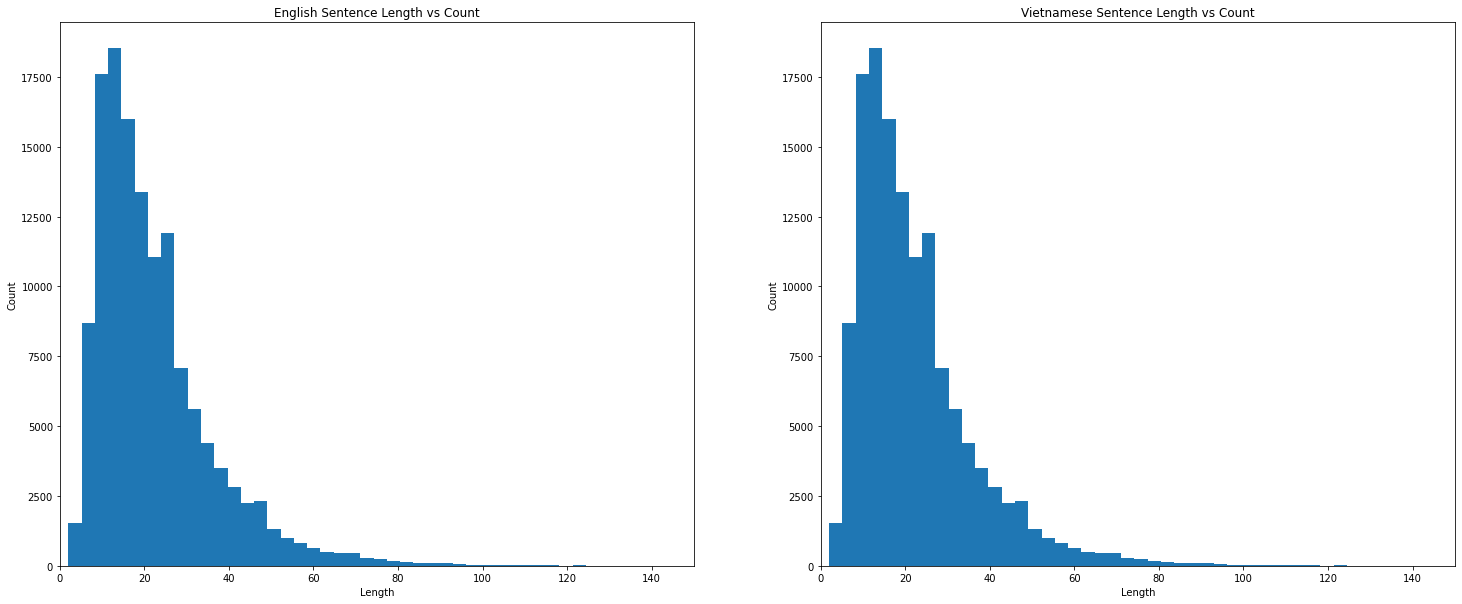

In [8]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(25,10))
ax0=fig.add_subplot(1,2,1)
ax0.hist(len_en,bins=200);
plt.xlim(0,150)
plt.ylabel("Count")
plt.xlabel("Length")
plt.title("English Sentence Length vs Count");
ax1=fig.add_subplot(1,2,2)
ax1.hist(len_en,bins=200);
plt.xlim(0,150)
plt.ylabel("Count")
plt.xlabel("Length")
plt.title("Vietnamese Sentence Length vs Count");

In [9]:
print("{:.2f} % of sentences in Vietnamese with length greater than {}".format((len_vi>90).sum()/len(vi)*100,90))  
print("{:.2f} % of sentences in English with length greater than {}".format((len_en>70).sum()/len(en)*100,70)) 
max_en=70
max_viet=90 

1.05 % of sentences in Vietnamese with length greater than 90
1.18 % of sentences in English with length greater than 70


Padding length for english=70

Padding length for Vietnames=90

In [0]:
def sent_to_index(train,max_len,word_idx):
  x_train=[]
  x_train_len=[]
  if isinstance(train,list): # there are many sentences that have the start and stop symbol
    for sent in tqdm(train): # sent represents a sentence in the list
      trial=[word_idx[word] if word in set(word_idx) else word_idx["<unk>"] for word in sent.split()]
      if len(trial) < max_len: # if the length is less than max fixed length then we pad and store the original length for packing
        x_train_len.append(len(trial))
        trial.extend(list(np.zeros(max_len-len(trial)).astype(int)))
        x_train.append(trial)
      else:
        x_train_len.append(max_len)
        x_train.append(trial[:max_len]) # we will only consider words upto the position of max_len
    
  if isinstance(train,str):
    trial=[word_idx[word] if word in set(word_idx) else word_idx["<unk>"] for word in train.split()]
    if len(trial) < max_len: # if the length is less than max fixed length then we pad and store the original length for packing
        x_train_len.append(len(trial))
        trial.extend(list(np.zeros(max_len-len(trial)).astype(int)))
        x_train.append(trial)
    else:
        x_train_len.append(max_len)
        x_train.append(trial[:max_len]) # we will only consider words upto the position 
  
  
  return np.array(x_train),np.array(x_train_len)


In [0]:
x_train,x_train_len=sent_to_index(en,max_en,eng_idx)

'x_train,x_train_len=sent_to_index(en,max_en,eng_idx)'

In [0]:
y_train,y_train_len=sent_to_index(vi,max_viet,viet_idx)

In [0]:
np.save('/content/drive/My Drive/nmt/x_train.npy',x_train)
np.save('/content/drive/My Drive/nmt/x_train_len.npy',x_train_len)
np.save('/content/drive/My Drive/nmt/y_train.npy',y_train)
np.save('/content/drive/My Drive/nmt/y_train_len.npy',y_train_len)

# So far we have completed the preprocessing and padding steps

In [0]:
X_train=np.load('/content/drive/My Drive/nmt/x_train.npy')
X_train_len=np.load('/content/drive/My Drive/nmt/x_train_len.npy')
Y_train=np.load('/content/drive/My Drive/nmt/y_train.npy')
Y_train_len=np.load('/content/drive/My Drive/nmt/y_train_len.npy')
x_train,x_test,y_train,y_test,x_train_len,x_test_len,y_train_len,y_test_len=train_test_split(X_train,Y_train,X_train_len,Y_train_len,test_size=0.2,random_state=101)

In [0]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, X,X_len ,Y,Y_len):
        self.data = X
        self.target = Y
        
        self.length1 =X_len
        self.length2 =Y_len

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length1[index]
        y_len = self.length2[index]
        return x,y,x_len,y_len
    
    def __len__(self):
        return len(self.data)



In [0]:
xtrain = MyData(x_train,x_train_len,y_train,y_train_len)
xtest = MyData(x_test,x_test_len,y_test,y_test_len)
train_loader=torch.utils.data.DataLoader(xtrain,batch_size=32,shuffle=False,drop_last=True)
test_loader=torch.utils.data.DataLoader(xtest,batch_size=32,shuffle=False,drop_last=True)

In [0]:
vocab_en=len(eng_idx)
vocab_vi=len(viet_idx)

In [0]:
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X, y, lengths 

def sort_batch_new(X, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    return X, lengths 

In [16]:
len(train_loader),len(test_loader)

(3332, 833)

In [17]:
X_train

array([[ 2,  4,  1, ...,  0,  0,  0],
       [ 2, 12, 13, ...,  0,  0,  0],
       [ 2, 48, 49, ...,  0,  0,  0],
       ...,
       [ 2,  3,  0, ...,  0,  0,  0],
       [ 2,  1,  1, ...,  0,  0,  0],
       [ 2,  6,  1, ...,  0,  0,  0]])

# Model for training

In [0]:
class Encoder(nn.Module):
  def __init__(self,vocab_en,emb_dim,hidden_dim):
    super(Encoder,self).__init__()

    self.embeds = nn.Embedding(vocab_en, emb_dim)

    self.GRU = nn.GRU(emb_dim,hidden_dim,num_layers=1,batch_first=True,bidirectional=True)

    self.reduce_hid = nn.Linear(hidden_dim * 2, hidden_dim)

    self.dropout = nn.Dropout(0.5)
  
  def forward(self,x,len_x):
    # input x has the shape:(batch_size,seq_length)
    
    x = self.dropout(self.embeds(x)) 
    # after embedding the shape: (batch_size,longest seq_length, emb_dim)
    
    packed = torch.nn.utils.rnn.pack_padded_sequence(x, len_x, batch_first=True)
    # packing is done to efficiently run through the different padded instances

    enc_out, enc_hid = self.GRU(packed)
    # enc_hid.shape : (2,batch_size,hidden_dim)Output for the last time step

    enc_out , _ = torch.nn.utils.rnn.pad_packed_sequence(enc_out, batch_first=True,padding_value=0,total_length=70)
    #enc_out , _ = torch.nn.utils.rnn.pad_packed_sequence(enc_out, batch_first=True)#,padding_value=0,total_length=70)
    # enc_out.shape : (batch_size,long_seq_length,2*hidden_dim) cause we use a bidirectional GRU
    enc_out = enc_out.contiguous()
 
    enc_hid = torch.cat(list(enc_hid), dim=1)
    # enc_hid.shape : batch_size,2*hidden_dim
    enc_hid = F.relu(self.reduce_hid(enc_hid))
    # enc_hid.shape : batch_size,hidden_dim


    return enc_out,enc_hid



In [0]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias = False)
        
    def forward(self, encoder_outputs, hidden, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  

        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention* mask
        return F.softmax(attention, dim = 1)

In [0]:
class Decoder(nn.Module):
  def __init__(self,vocab_vi,emb_dim,hidden_dim):
    super(Decoder,self).__init__()
    # used for the decoder
    self.x_context = nn.Linear(hidden_dim*2 + emb_dim, emb_dim)

    self.embeds = nn.Embedding(vocab_vi, emb_dim)

    self.GRU = nn.GRU(emb_dim,hidden_dim,num_layers=1,batch_first=True)

    self.out = nn.Linear(hidden_dim , vocab_vi)

    self.attention = Attention(hidden_dim)

    self.dropout = nn.Dropout(0.5)

  def forward(self,enc_out,dec_hid,x,mask):
    #enc_out: encoder output for all the states (bz,seq,2*hid)
    #dec_hid: Hidden state output for the last state (bz,hid) represents the hidden state rep of the decoder
    #x: input to the decoder, mostly the output of the previous time step
    #mask: shape (bz,sq)
    attention_weights = self.attention(enc_out,dec_hid,mask) 
    # attention_weights shape (bz,seq)
    attention_weights = attention_weights.unsqueeze(1)
    # attention_weights shape (bz,1,seq)

    context_vector = torch.bmm(attention_weights, enc_out)
    # contect vector shape : (bz,1,2*hid)

    """context_vector = torch.sum(context_vector, dim=1)
    # contect_vector shape : (bz,2*hid)"""

    x = self.dropout(self.embeds(x)) 
    # after embedding the shape: (batch_size,1, emb_dim)

    """context_vector =  context_vector.unsqueeze(1)
    # context_vector shape:((bz,1,2*hid))"""
    
    #print(context_vector.shape,x.shape)
    x = torch.cat((context_vector, x), -1)
    # x shape: (bz,1,2*hidden+emb)

    x = self.x_context(x)
    # x shape: (bz,seq,emb)

    dec_hid = dec_hid.unsqueeze(0)
    # dec_hid shape: (1,bz,hid)

    dec_out, dec_hid = self.GRU(x,dec_hid)
    # dec_out.shape : batch_size,1,hidden_dim 
    # dec_hid.shape : 1,batch_size,hidden_dim

    dec_out =  dec_out.view(-1, dec_out.size(2))
    # dec_out.shape : batch_size,hidden_dim 

    
    dec_out = self.out(dec_out)
    # dec_out.shape : batch_size,vocab_dim     

    return dec_out,dec_hid,attention_weights.squeeze(2)



In [0]:

class Model(nn.Module):
    def __init__(self,vocab_en,vocab_vi,emb_dim,hid_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(vocab_en,emb_dim,hid_dim)
        self.decoder = Decoder(vocab_vi,emb_dim,hid_dim)
        self.dec_vocab_len = vocab_vi

        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
    
    def forward(self,x_train,x_len,y_train,mask,teacher_forcing_ratio = 0.5):

        enc_op,enc_hid=model.encoder(x_train,x_len)
        # enc_hid.shape : (batch_size,hidden_dim)
        # enc_out.shape : (batch_size,long_seq_length,2*hidden_dim)
        
        #To store the outputs of the decoder
        outputs = torch.zeros(y_train.shape[0],y_train.shape[1],self.dec_vocab_len).to(device)
        # outputs shape : (bz,sq,vocab_viet)

        dec_in = y_train[:,0].unsqueeze(1)
        # dec_in: (bz,1)
        dec_hid = enc_hid
        for t in range(1,y_train.shape[1]):
            if len(dec_hid.shape)==3:
              dec_hid = dec_hid.squeeze(0)
            #print("Dec_in:{}".format(dec_in.shape))
            dec_out,dec_hid,_ = model.decoder(enc_op,dec_hid,dec_in,mask)
            #dec_hid = dec_hid.squeeze(0)
            outputs[:,t,:] = dec_out

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = dec_out.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            dec_in = y_train[:,t] if teacher_force else top1
            dec_in = dec_in.unsqueeze(1)
            

        
        return outputs



In [0]:
model=Model(vocab_en,vocab_vi,256,512)

In [29]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Model(
  (encoder): Encoder(
    (embeds): Embedding(17192, 256)
    (GRU): GRU(256, 512, batch_first=True, bidirectional=True)
    (reduce_hid): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (x_context): Linear(in_features=1280, out_features=256, bias=True)
    (embeds): Embedding(7710, 256)
    (GRU): GRU(256, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=7710, bias=True)
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

# Trial run  to check the execution of shapes and sizes

In [24]:
print("Checking the Encoder")
print("____________________")
t=iter(train_loader)
x_train,y_train,x_len,_=t.next()
print(x_train.shape,y_train.shape,x_len.shape)
x_train,y_train,x_len=sort_batch(x_train,y_train,x_len)
mask=torch.IntTensor((x_train!=0).numpy().astype(int)).to(device)
enc_op,enc_hid=model.encoder(x_train.to(device),x_len.to(device))
print("Encoder output shape:{}".format(enc_op.shape))
print("Encoder hidden shape:{}".format(enc_hid.shape))

Checking the Encoder
____________________
torch.Size([32, 70]) torch.Size([32, 90]) torch.Size([32])
Encoder output shape:torch.Size([32, 70, 1024])
Encoder hidden shape:torch.Size([32, 512])


In [25]:
print("Checking the Decoder")
print("____________________")

dec_out,dec_hid,attention_weights=model.decoder(enc_op,enc_hid,y_train[:,0].unsqueeze(1).to(device),mask)
print("Decoder output shape:{}".format(dec_out.shape))
print("Decoder hidden shape:{}".format(dec_hid.shape))
print("Attention Weights shape:{}".format(attention_weights.shape))


Checking the Decoder
____________________
Decoder output shape:torch.Size([32, 7710])
Decoder hidden shape:torch.Size([1, 32, 512])
Attention Weights shape:torch.Size([32, 1, 70])


In [26]:
print("Checking the complete mechanism")
print("____________________")
t=iter(train_loader)
x_train,y_train,x_len,_=t.next()
print(x_train.shape,y_train.shape,x_len.shape)
x_train,y_train,x_len=sort_batch(x_train,y_train,x_len)
mask=torch.IntTensor((x_train!=0).numpy().astype(int)).to(device)
op = model(x_train.to(device),x_len.to(device),y_train.to(device),mask,0.5)
print(op)

Checking the complete mechanism
____________________
torch.Size([32, 70]) torch.Size([32, 90]) torch.Size([32])
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-7.1310e-05,  4.2458e-05, -3.4725e-05,  ..., -3.6868e-05,
          -1.2066e-05,  4.6723e-05],
         [-2.5080e-05,  3.0143e-05, -1.1467e-05,  ...,  4.0069e-05,
          -4.7796e-07, -1.6539e-05],
         ...,
         [ 3.5137e-05, -7.2501e-05, -2.0098e-05,  ...,  3.1209e-05,
          -4.2800e-05,  6.2380e-05],
         [-3.1807e-06, -3.2893e-05,  1.9954e-06,  ...,  5.3397e-05,
          -1.2517e-05,  4.1163e-05],
         [ 2.9020e-06, -5.5189e-06,  8.2915e-06,  ...,  4.7012e-05,
          -5.0628e-05,  5.6214e-05]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-4.6170e-05,  2.3149e-05,  8.2825e-05,  ..., -2.2612e-05,
          -4.5783e-05,  1.6815e-05],
         [-2.8147e-05,  2.1029e-

# Seems good so far

In [0]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [31]:
model.parameters

<bound method Module.parameters of Model(
  (encoder): Encoder(
    (embeds): Embedding(17192, 256)
    (GRU): GRU(256, 512, batch_first=True, bidirectional=True)
    (reduce_hid): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (x_context): Linear(in_features=1280, out_features=256, bias=True)
    (embeds): Embedding(7710, 256)
    (GRU): GRU(256, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=7710, bias=True)
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
)>

In [0]:
def train(model, train_loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for batch,(x_train,y_train,x_len,_) in enumerate(tqdm(train_loader)):

        x_train,y_train,x_len=sort_batch(x_train,y_train,x_len)
        mask=torch.IntTensor((x_train!=0).numpy().astype(int)).to(device)
        x_train,x_len,y_train=x_train.to(device),x_len.to(device),y_train.to(device)
        
        
        optimizer.zero_grad()
        
        output = model(x_train,x_len,y_train,mask,0.5)
        
        
        
        output_dim = output.shape[-1]
        
        output = output[:,1:].reshape(-1, output_dim)
        y_train = y_train[:,1:].reshape(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, y_train)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

In [0]:
def evaluate(model, test_loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for batch,(x_train,y_train,x_len,_) in enumerate(tqdm(test_loader)):

            x_train,y_train,x_len=sort_batch(x_train,y_train,x_len)
            mask=torch.IntTensor((x_train!=0).numpy().astype(int)).to(device)
            x_train,x_len,y_train=x_train.to(device),x_len.to(device),y_train.to(device)

            
            optimizer.zero_grad()
        
            output = model(x_train,x_len,y_train,mask,0)
        
            
            output_dim = output.shape[-1]
        
            output = output[:,1:].reshape(-1, output_dim)
            y_train = y_train[:,1:].reshape(-1)

  

            loss = criterion(output, y_train)

            epoch_loss += loss.item()
        
    return epoch_loss / len(test_loader)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/nmt/model_a2.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 4.993 | Test PPL: 147.432 |


In [0]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [0]:
N_EPOCHS = 10


best_valid_loss = test_loss

for epoch in range(10,10+N_EPOCHS):
    
    start_time = time.time()
    

    train_loss = train(model, train_loader, optimizer, criterion, 1)
    valid_loss = evaluate(model, test_loader, criterion)
    
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/nmt/model_a3.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Perplexity: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Perplexity: {math.exp(valid_loss):7.3f}')


Epoch: 11 | Time: 28m 28s
	Train Loss: 3.618 | Train Perplexity:  37.278
	 Val. Loss: 5.033 |  Val. Perplexity: 153.391



Epoch: 12 | Time: 28m 29s
	Train Loss: 3.525 | Train Perplexity:  33.955
	 Val. Loss: 4.999 |  Val. Perplexity: 148.295



Epoch: 13 | Time: 28m 26s
	Train Loss: 3.466 | Train Perplexity:  32.012
	 Val. Loss: 4.988 |  Val. Perplexity: 146.675



Epoch: 14 | Time: 28m 24s
	Train Loss: 3.419 | Train Perplexity:  30.526
	 Val. Loss: 5.017 |  Val. Perplexity: 150.898



Epoch: 15 | Time: 28m 30s
	Train Loss: 3.376 | Train Perplexity:  29.268
	 Val. Loss: 5.009 |  Val. Perplexity: 149.739



Epoch: 16 | Time: 28m 32s
	Train Loss: 3.335 | Train Perplexity:  28.067
	 Val. Loss: 4.980 |  Val. Perplexity: 145.430



Epoch: 17 | Time: 28m 28s
	Train Loss: 3.295 | Train Perplexity:  26.975
	 Val. Loss: 5.007 |  Val. Perplexity: 149.416



Epoch: 18 | Time: 28m 28s
	Train Loss: 3.262 | Train Perplexity:  26.094
	 Val. Loss: 4.998 |  Val. Perplexity: 148.069



Epoch: 19 | Time: 28m 29s
	Train Loss: 3.227 | Train Perplexity:  25.216
	 Val. Loss: 5.015 |  Val. Perplexity: 150.667


In [0]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/nmt/model_a2.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 4.971 | Test PPL: 144.145 |


In [0]:
N_EPOCHS = 10


best_valid_loss = test_loss

for epoch in range(18,18+N_EPOCHS):
    
    start_time = time.time()
    

    train_loss = train(model, train_loader, optimizer, criterion, 1)
    valid_loss = evaluate(model, test_loader, criterion)
    
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/nmt/model_a3.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Perplexity: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Perplexity: {math.exp(valid_loss):7.3f}')


# Loading trained model

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/nmt/model_a2.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 4.971 | Test PPL: 144.145 |


In [48]:
model.load_state_dict(torch.load('/content/drive/My Drive/nmt/model_a2.pt'))

<All keys matched successfully>

In [0]:
def translate_sentence(sentence, eng_idx, viet_idx, model, max_len = 90):

    model.eval()
        
    if isinstance(sentence, str):
      sentence = idx_eng[2]+" "+sentence+" "+idx_eng[3] # Padding sentence with start and end token if its a single sentence
    
            
        
    src_indexes,src_len = sent_to_index(sentence,70,eng_idx)

    src_tensor = torch.LongTensor(src_indexes).to(device)

    src_len = torch.LongTensor(src_len).to(device)

    if src_tensor.shape[0] != 1: # incase sentence is a collection of sentences
      src_tensor,src_len=sort_batch_new(src_tensor,src_len)

    #mask=torch.IntTensor((src_indexes!=0).astype(int)).to(device)
    mask=torch.IntTensor((src_tensor!=0).cpu().numpy().astype(int)).to(device)
    
    
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        # encoder_outputs shape:(bz,70,1024)
        # hidden shape:(bz,512)

    
        
    trg_indexes = [viet_idx['<s>']]*src_tensor.shape[0]

    attentions = torch.zeros( src_tensor.shape[0],max_len, src_indexes.shape[1]).to(device)
    
    for i in range(max_len):
        
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        if len(hidden.shape)==3:
              hidden = hidden.squeeze(0)
        if len(trg_tensor.shape)==1:
              trg_tensor = trg_tensor.unsqueeze(1)
           
        with torch.no_grad():
            output, hidden, attention = model.decoder(encoder_outputs,hidden,trg_tensor,mask)  

        attentions[:,i,:] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == viet_idx['</s>']:
            break
    
    trg_tokens = [idx_viet[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:,:len(trg_tokens)-1,:]

In [0]:
sentence="And these are the questions that we have to worry about for the next 50 years ."

In [0]:
a,b=translate_sentence(sentence, eng_idx, viet_idx, model, max_len = 90)

In [0]:
print(" ".join(a[:-1]))

Và đây là những câu hỏi mà chúng ta phải lo lắng về 50 năm tới .


In [0]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(0)[:,:len(sentence.split())+1].cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='BuGn_r',)
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['<s>']+[t for t in sentence.split()]+['</s>'], 
                       rotation=45)
    ax.set_yticklabels(['<s>']+translation)
    fig.colorbar(cax, ax=ax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

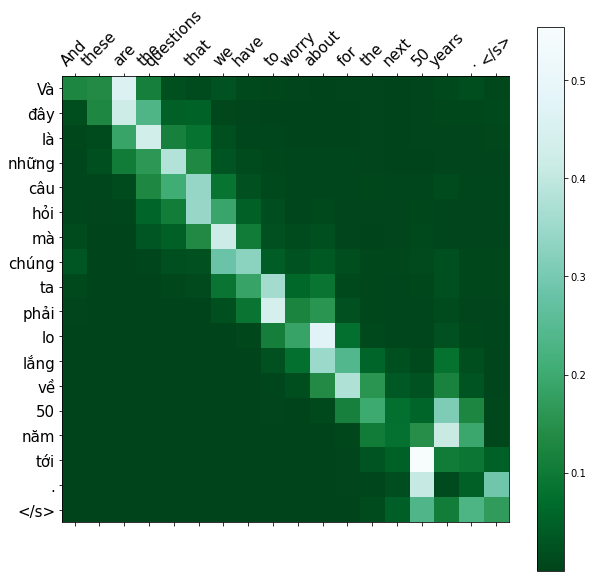

In [0]:
display_attention(sentence,a,b)

# Bleu Score

In [0]:
def create_testing(s):
  train=[]
  with open(s) as f:
    for line in f:
      train.append([(line[:-1]).split()])
  return train



In [0]:
# specifically to get sentences in the format of list within a list to calculate BLEU SCORE with the output
vi_test = create_testing('/content/drive/My Drive/nmt/tst2012_vi.txt')
# for evaluation the test data input
en_train,len_en_train = create_training('/content/drive/My Drive/nmt/tst2012_en.txt')
testing=list(vi_test)

In [52]:
result=[]
for sent in tqdm(en_train):
  a,_=translate_sentence(sent[4:-5], eng_idx, viet_idx, model, max_len = 90)
  result.append(a[:-1])


In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [0]:
from nltk.translate.bleu_score import SmoothingFunction

In [0]:
chencherry = SmoothingFunction(epsilon=0.1, alpha=5, k=5)

score = corpus_bleu(vi_test, result,smoothing_function=chencherry.method1)

In [57]:
score*100

16.38770639804857

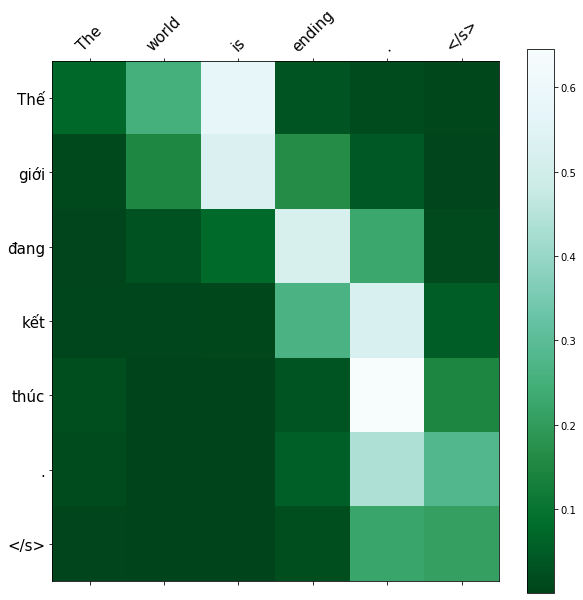

Thế giới đang kết thúc .


In [0]:
sent="The world is ending ."
a,b=translate_sentence(sent, eng_idx, viet_idx, model, max_len = 90)
display_attention(sent,a,b)
print(" ".join(a[:-1]))

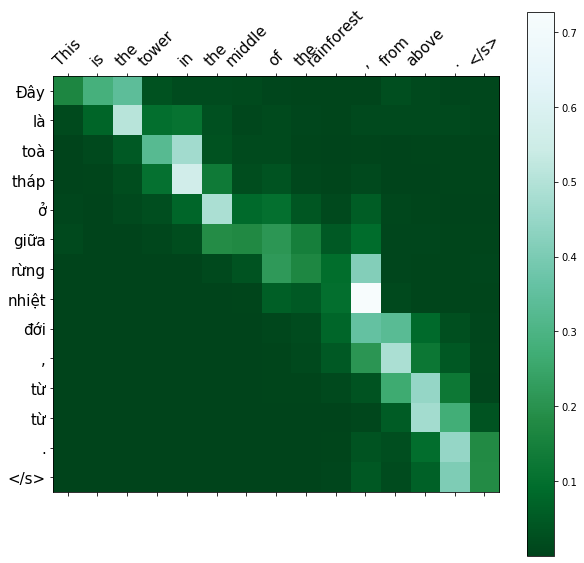

Đây là toà tháp ở giữa rừng nhiệt đới , từ từ .


In [0]:
sent="This is the tower in the middle of the rainforest , from above ."
a,b=translate_sentence(sent, eng_idx, viet_idx, model, max_len = 90)
display_attention(sent,a,b)
print(" ".join(a[:-1]))